In [1]:
import sys

sys.path.insert(0, "../.")

In [10]:
!python --version

Python 3.8.20


In [2]:
import os
import grid2op
from lightsim2grid.lightSimBackend import LightSimBackend
from package.make_agent import make_agent_topoNN, make_agent_challenge
from package.modules.rewards import MaxRhoReward

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
2025-10-24 21:18:38.086558: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 21:18:38.088255: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 21:18:38.119172: I tensorflow/core/platform/cpu_feature_gua

## Instantiate environment
Our agent is using greedy search mechanism based on a reward function. Hence one should specify a relevent reward function and pass it as an arg for the env.

In [3]:
env = grid2op.make('l2rpn_idf_2023',backend = LightSimBackend(), reward_class = MaxRhoReward)

## Instantiate the agent
### Heuristic version of our agent used during the challenge 

In [4]:
agent_heuristic = make_agent_challenge(env, ".")

In [5]:
agent_heuristic

### Enhanced version with neural network based policy for topological decision for unsafe state

In [4]:
agent_topo_nn = make_agent_topoNN(env, ".")

/home/milad/miniconda3/envs/l2rpn_baselines/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() takes at most 16 arguments (18 given)
  warnings.warn(
/home/milad/miniconda3/envs/l2rpn_baselines/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() takes at most 16 arguments (18 given)
  warnings.warn(


In [5]:
act = env.action_space({})
observation = env.reset()
reward = None
tested_actions = agent_topo_nn.topo_12_unsafe._get_tested_action(observation)
action = agent_topo_nn.topo_12_unsafe.get_act(observation, act, reward)
print(action)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element(s):
	 	 - Assign bus 2 to line (extremity) id 2 [on substation 11]
	 	 - Assign bus 1 to line (extremity) id 13 [on substation 11]
	 	 - Assign bus 1 to line (extremity) id 24 [on substation 11]
	 	 - Assign bus 1 to line (extremity) id 35 [on substation 11]
	 	 - Assign bus 2 to line (origin) id 57 [on substation 11]
	 	 - Assign bus 1 to line (origin) id 80 [on substation 11]
	 	 - Assign bus 2 to line (origin) id 83 [on substation 11]
	 	 - Assign bus 1 to generator id 6 [on substation 11]
	 	 - Assign bus 1 to load id 8 [on substation 11]
	 - Not raise any alert


In [13]:
tmp = env.action_space({})
for key, value in tmp.to_json().items():
     value = tested_actions[5].to_json()[key] 

## Evaluate the agents

In [6]:
from grid2op.Runner import Runner

In [7]:
env.chronics_handler.max_episode_duration()

2017

In [8]:
verbose = True
runner_params = env.get_params_for_runner()
runner_params["verbose"] = verbose
logs_path = "logs"

# Build the runner
runner = Runner(**runner_params, 
                agentClass=None, 
                agentInstance=agent_topo_nn)

if logs_path is not None:
    os.makedirs(logs_path, exist_ok=True)
    
results = runner.run(
    path_save=logs_path,
    nb_episode=1,
    nb_process=1,
    max_iter=env.chronics_handler.max_episode_duration(),
    pbar=verbose,
)

episode:   0%|          | 0/1 [00:00<?, ?it/s]calling NN module
calling optim module
calling NN module
calling recovery module (safe)
calling NN module
calling recovery module
calling optim module
Problem diverged with dc approximation for OSQP: Solver 'OSQP' failed. Try another solver, or solve with verbose=True for more information.
compute_optimum_unsafe: Problem diverged. No continuous action will be applied.
calling NN module
calling optim module
calling recovery module (safe)
calling recovery module (safe)
calling reconnection module
calling reconnection module
calling n1 module
calling reconnection module
calling reconnection module
calling reconnection module
calling NN module
calling optim module
calling recovery module
calling NN module
calling recovery module
calling optim module
calling recovery module
calling optim module
calling NN module
calling optim module
calling reconnection module
calling reconnection module
calling reconnection module
calling reconnection module
ca

## Save the GIF and show summary

Evaluation summary:
chronics at: 2035-01-01_0	total score: 1024.937134	time steps: 913/2017
Creating 2035-01-01_0.gif


/home/milad/miniconda3/envs/javagent/lib/python3.10/site-packages/grid2op/PlotGrid/PlotMatplot.py:321: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  figure.canvas.print_raw(buf)
/home/milad/miniconda3/envs/javagent/lib/python3.10/site-packages/grid2op/Episode/EpisodeReplay.py:207: UserWarning: Failed to optimize .GIF size, but gif is still saved:
Install dependencies to reduce size by ~3 folds
apt-get install gifsicle && pip3 install pygifsicle
  warnings.warn(warn_msg)


Wrote logs/2035-01-01_0/2035-01-01_0.gif


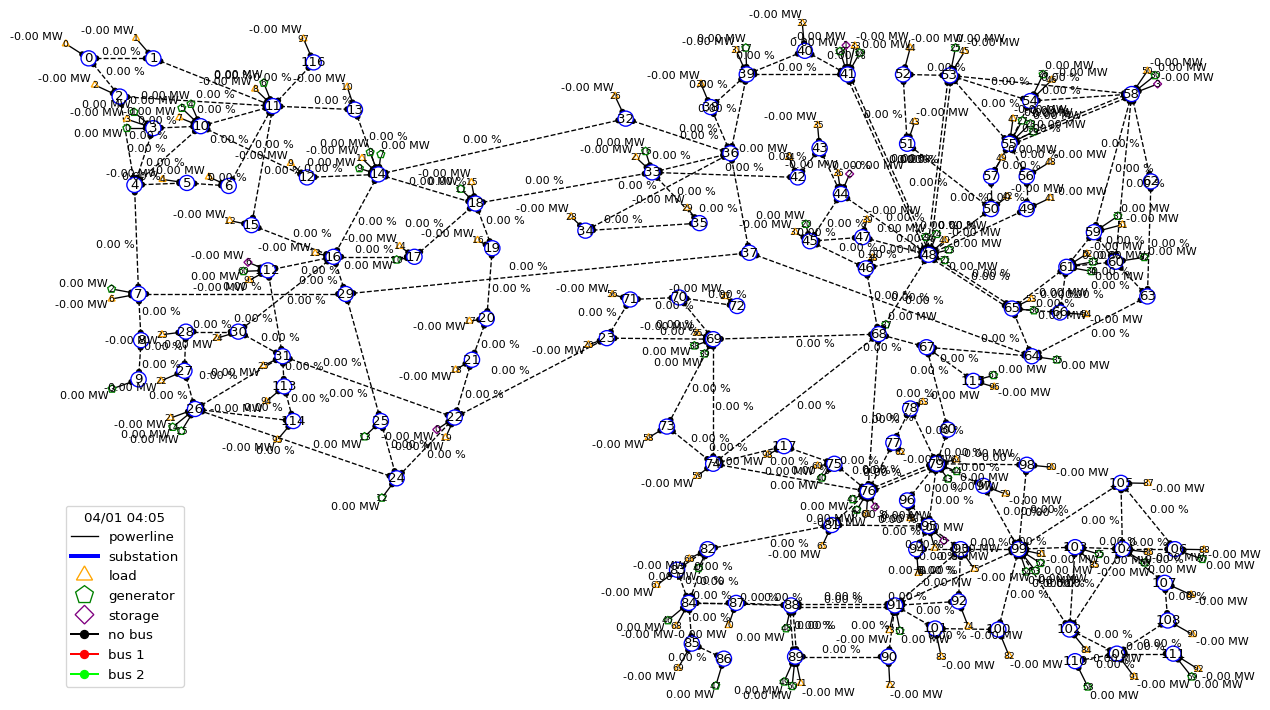

In [9]:
from l2rpn_baselines.utils.save_log_gif import save_log_gif

save_gif = True
logs_path = "logs"

print("Evaluation summary:")
for _, chron_name, cum_reward, nb_time_step, max_ts in results:
    msg_tmp = "chronics at: {}".format(chron_name)
    msg_tmp += "\ttotal score: {:.6f}".format(cum_reward)
    msg_tmp += "\ttime steps: {:.0f}/{:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

if save_gif:
    save_log_gif(logs_path, results)